# Import packages and modules

In [1]:
import os, glob
import json
import pandas as pd
import numpy as np
import math, random
import datetime as dt
import pickle
from matplotlib import pyplot as plt
import argparse
import path, sys, re, time
from collections import Counter
from scipy.spatial import distance_matrix
from scipy.signal import find_peaks


from module_.info.testbed import activityfiles_new
from module_.info.config import config, feature_name
from module_.readText import create_episodes, time_correction
from module_.featureExtraction import feature_extraction
from module_.changePointDetection import change_point_detection

# Data Collection and Preprocessing

In [2]:
"""
load raw files
"""

dir_="dataset/testbed/npy/seminar/MS"
task_dict={i:[np.load("{}/{}".format(dir_, name)) for name in v] for i, v in enumerate(activityfiles_new.values())}
initial_dict={i:k[0] for i, k in enumerate(activityfiles_new.keys())}
label_dict={k[0]:k for k in activityfiles_new.keys()}

episodes, trs, tags = create_episodes(task_dict, initial_dict)
episodes=[time_correction(eps, trs[i]) for i, eps in enumerate(episodes)]

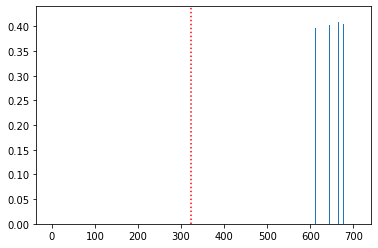

In [3]:
data_name = 'testbed'
metric = 'RuLSIF'

folder = "./features/{}".format(data_name)
if not os.path.exists(folder):
    os.mkdir(folder)

# fig = plt.figure(constrained_layout=True, figsize=(15, 15))

sensor_set=set()

for _, v in task_dict.items():
    for v_ in v:
        sensor_set = sensor_set | set(np.array(v_)[:,0])
sensor_list=sorted(sensor_set)

for ei, eps in enumerate(episodes):
    activityfolder="{}/{}".format(folder, tags[ei])
    if not os.path.exists(activityfolder):
        os.mkdir(activityfolder)
    eps=np.array(eps)
    
    features = np.array(feature_extraction(eps, data_name, sensor_list))

    assert len(eps)==len(features)
    
    x_ = range(len(eps))

    scores = np.array(change_point_detection(features, data_name, metric))
    scores[scores<0]=0

    assert len(eps)==len(scores)

    plt.bar(range(len(scores)), scores); plt.axvline(x=trs[ei], linestyle=':', color='r')
    break